In [1]:
"""
Name: con_example.ipynb
Authors: Christian Haack, Stephan Meighen-Berger
Example of the realistic simulations that can be done
"""
%load_ext autoreload
%autoreload 2

In [2]:
 # General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from contagion import Contagion, config
from contagion.config import _baseconfig

In [55]:
my_config = dict(_baseconfig)
my_config["population"]["population size"] = 100000
my_config["population"]["population class"] = "AccuratePopulation"
my_config["population"]["population storage"] = "../populations/{}_{}.pkl".format(
    my_config["population"]["population class"],
    my_config["population"]["population size"])
my_config["population"]["social circle interactions pdf"]["mean"] = 5
my_config["population"]["social circle pdf"]["mean"] = 50
my_config["population"]["re-use population"] = False
my_config["population"]["store population"] = True
my_config["population"]["random interactions pdf"]["mean"] = 10
my_config["population"]["random interactions pdf"]["sd"] = 5
my_config["population"]["random interactions intensity pdf"]["mean"] = 0.05
my_config["population"]["random interactions intensity pdf"]["sd"] = 2
my_config["scenario"]["sim_length"] = 150
my_config["infection"]["infected"] = 1
my_config['infection']['infection probability pdf']['mean'] = 2.
my_config['infection']['infection probability pdf']['sd'] = 1.42
my_config['infection']['infection probability pdf']['max_val'] = 0.15
contagion = Contagion(my_config)


In [56]:
my_config["population"]["re-use population"] = True

In [60]:
results = []
t_durs = [None, 14, 28, 42, 56, 63]
t_start = 14
for t_dur in t_durs:
    if t_dur is None:
        my_config["scenario"]["class"] = "StandardScenario"
    else:    
        my_config["scenario"]["class"] = "SocialDistancing"
        my_config["scenario"]["t_start"] = t_start
        my_config["scenario"]["t_stop"] = t_start + t_dur
        my_config["scenario"]["contact_rate_scaling"] = 0.05
        
        
    contagion = Contagion(my_config)
    contagion.sim()
    stats = pd.DataFrame(contagion.statistics)
    results.append(stats)
        
        

In [61]:
# Plotting standards
std_size = 10.
fontsize = 15.
lw=3.
h_length=1.

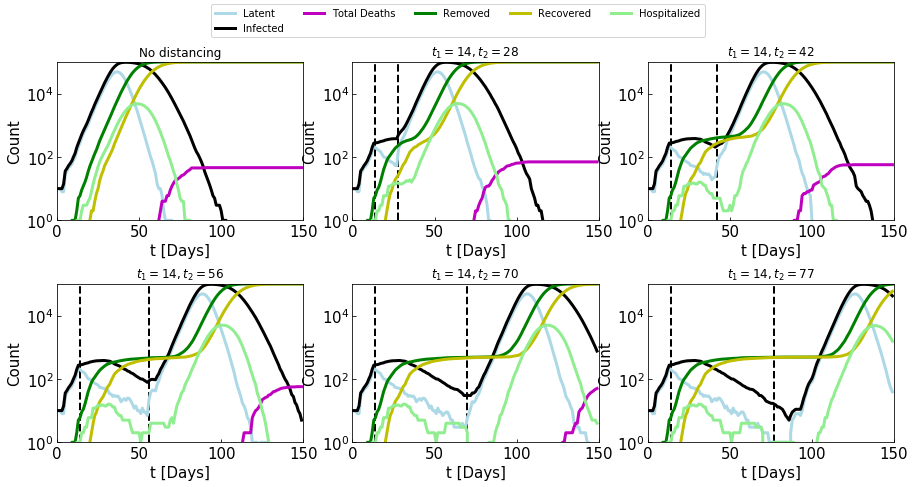

In [62]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
for ts, res, ax in zip(t_durs, results, axs.ravel()):
     # Infections per time step

    if ts is not None:
        ax.axvline(t_start, ls="--", lw=2, color="k")
        ax.axvline(ts+t_start, ls="--", lw=2, color="k")
    ax.plot(contagion.t, res['is_latent'],
            lw=lw, label='Latent', color="lightblue")
    ax.plot(contagion.t, res['is_infected'],
            lw=lw, label='Infected', color="k")
    ax.plot(contagion.t, res['is_dead'],
            lw=lw, label='Total Deaths', color="m")
    ax.plot(contagion.t, res['is_removed'],
            lw=lw, label='Removed', color='g')
    ax.plot(contagion.t, res['is_recovered'],
            lw=lw, label='Recovered', color='y')
    ax.plot(contagion.t, res['is_hospitalized'],
            lw=lw, label='Hospitalized', color='lightgreen')
   
    ax.set_xlim(0, 150)
    ax.set_ylim(1., config["population"]['population size'] * 1.01)
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_xlabel(r't [Days]', fontsize=fontsize)
    ax.set_ylabel(r'Count', fontsize=fontsize)
    ax.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
    ax.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
    h, l = ax.get_legend_handles_labels()
    if ts is None:
        ax.set_title("No distancing")
    else:
        ax.set_title("$t_1 ="+str(t_start)+", t_2="+str(t_start+ts)+"$")
plt.subplots_adjust(hspace=0.4)  
plt.figlegend(h, l, ncol=5, loc="upper center")

plot_name = "Contagion_SocialDistancing_{}.png".format(my_config["population"]["population class"])

plt.savefig(PICS + plot_name, bbox_inches='tight')

In [30]:
# Creating a contagion object


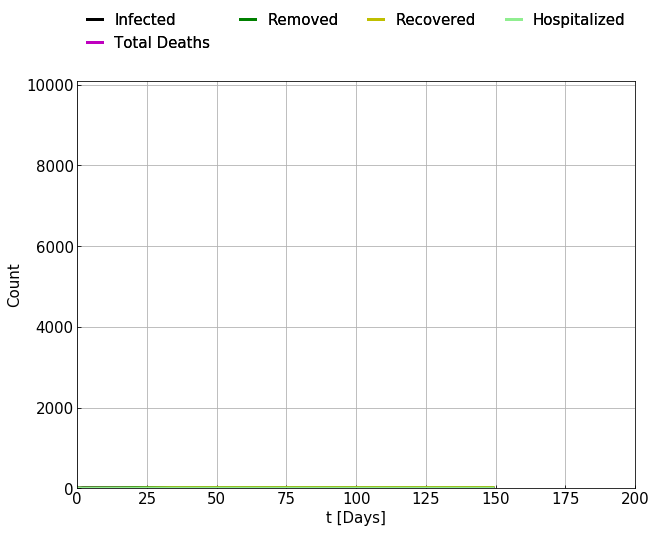

In [40]:
 # Infections per time step
figure, ax = plt.subplots(figsize=(std_size, std_size * 6. / 8.))

ax.plot(contagion.t, stats['is_infected'],
        lw=lw, label='Infected', color="k")
ax.plot(contagion.t, stats['is_dead'],
        lw=lw, label='Total Deaths', color="m")
ax.plot(contagion.t, stats['is_removed'],
        lw=lw, label='Removed', color='g')
ax.plot(contagion.t, stats['is_recovered'],
        lw=lw, label='Recovered', color='y')
ax.plot(contagion.t, stats['is_hospitalized'],
        lw=lw, label='Hospitalized', color='lightgreen')

ax.set_xlim(0, 200)
ax.set_ylim(0., config["population"]['population size'] * 1.01)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r't [Days]', fontsize=fontsize)
ax.set_ylabel(r'Count', fontsize=fontsize)
ax.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax.get_legend_handles_labels()
lgd1 = ax.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                 ncol=4, fontsize=fontsize, handlelength=h_length,
                 fancybox=True, frameon=False)
ax.add_artist(lgd1)
plt.grid(True)
plt.show()

In [ ]:
 # Infections per time step
figure, ax = plt.subplots(figsize=(std_size, std_size * 6. / 8.))
colors = ['#fdcc8a',
          '#fc8d59',
          '#d7301f']
ax.plot(contagion.t, stats['is_infectious'],
        lw=lw, label='Infectious', color='r')
ax.plot(contagion.t, stats['can_infect'],
        lw=lw, label='Can infect', color='lightgrey')
ax.plot(contagion.t, stats['is_latent'],
        lw=lw, label='Latent', color='lightblue')
ax.plot(contagion.t, stats['is_incubation'],
        lw=lw, label='Incubation', color='b')
ax.plot(contagion.t, stats['is_infected'],
        lw=lw, label='Infected', color="k")
ax.plot(contagion.t, stats['is_dead'],
        lw=lw, label='Total Deaths', color="m")
ax.plot(contagion.t, stats['is_removed'],
        lw=lw, label='Removed', color='g')
ax.plot(contagion.t, stats['is_recovered'],
        lw=lw, label='Recovered', color='y')
ax.plot(contagion.t, stats['is_hospitalized'],
        lw=lw, label='Hospitalized', color='lightgreen')
ax.plot(contagion.t, stats['is_symptomatic'],
        lw=lw, label='Symptomatic', color='lightcoral')
ax.set_xlim(0, 200)
ax.set_ylim(0., config["population"]['population size'] * 1.01)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r't [Days]', fontsize=fontsize)
ax.set_ylabel(r'Count', fontsize=fontsize)
ax.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax.get_legend_handles_labels()
lgd1 = ax.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                 ncol=4, fontsize=fontsize, handlelength=h_length,
                 fancybox=True, frameon=False)
ax.add_artist(lgd1)
plt.grid(True)
plt.show()

In [12]:
figure.savefig(PICS + "Contagion_Example.png",
               bbox_inches='tight')